<center><span style="font-size:28px; font-weight:bold;">1 - Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">Nettoyage et analyse exploratoire</span><center>

**Notebook réalisé par Gary MAUGER en Octobre 2024.**

Cette mission concerne l’entreprise....

https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

Utilisation de Ml Flow pour faire le tracking de ce notebook :

Étapes pour vous positionner dans le bon dossier

1. **Ouvrir un terminal.**

2. **Activer l'environnement Conda** :
   ```bash
   conda activate DataScientist_Projet_7
   ```

3. **Naviguer jusqu'au dossier du projet :**
   - Utiliser la commande `cd` pour vous déplacer dans le répertoire contenant le projet. Par exemple :
     ```bash
     cd /Users/Gary/Documents/GitHub/P7_implementer_modele_scoring
     ```

4. **Vérifier à être dans le bon dossier :**
   - Utiliser la commande `ls` (ou `dir` sur Windows) pour lister les fichiers dans le dossier et vous assurer que le répertoire `mlruns` est bien présent.
     ```bash
     ls
     ```
   - le dossier `mlruns` doit être parmi les fichiers listés.

5. **Lancez MLflow UI :**
   - Exécuter la commande suivante pour démarrer l'interface utilisateur de MLflow :
     ```bash
     mlflow ui
     ```

Une fois cela fait, vous pourrez accéder à l'interface utilisateur de MLflow via votre navigateur en visitant `http://127.0.0.1:5000`. 

Nous pouvons spécifier un autre port pour lancer l'interface utilisateur de MLflow. Par exemple, utiliser le port `5001` en lançant la commande suivante :

```bash
mlflow ui --port 5001
```

Ensuite, accéder à l'interface MLflow via le navigateur à l'adresse `http://127.0.0.1:5001`.

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [8]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import missingno as msno

In [9]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
mlflow.end_run()

## 1.2 - Importation des données

In [11]:
# Initialiser MLFlow
mlflow.set_experiment("Home Credit Default Risk - EDA")

<Experiment: artifact_location='file:///Users/Gary/Documents/GitHub/P7_implementer_modele_scoring/mlruns/129726695521033290', creation_time=1725009641446, experiment_id='129726695521033290', last_update_time=1725009641446, lifecycle_stage='active', name='Home Credit Default Risk - EDA', tags={}>

In [12]:
mlflow.start_run(run_name="Importation des données")

<ActiveRun: >

In [13]:
# Listons les fichiers à notre disposition
display(os.listdir("/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk"))

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [16]:
with mlflow.start_run():
    start_time = time.time()
    
    # Importation des données
    df_application_train = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
    df_application_test = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')
    df_bureau = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv')
    df_credit_card_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv')
    df_bureau_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv')
    df_installments_payments = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv')
    df_POS_CASH_balance = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv')
    df_previous_application = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv')

    # Log des informations pertinentes
    mlflow.log_param("Train Rows", df_application_train.shape[0])
    mlflow.log_param("Test Rows", df_application_test.shape[0])
    mlflow.log_param("Bureau Rows", df_bureau.shape[0])
    mlflow.log_metric("Loading Time", time.time() - start_time)
    mlflow.log_artifact('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', artifact_path="datasets")

**Description du dataset provenant de Kaggle**

**Lien vers le dataset** : [https://www.kaggle.com/c/home-credit-default-risk/data](https://www.kaggle.com/c/home-credit-default-risk/data)

---

1. **application_{train|test}.csv**

   Il s'agit de la table principale, divisée en deux fichiers : un pour l'entraînement (avec la colonne TARGET) et un pour le test (sans la colonne TARGET). Données statiques pour toutes les demandes de prêt. Chaque ligne représente un prêt dans notre échantillon de données.

2. **bureau.csv**

   Tous les crédits précédents du client accordés par d'autres institutions financières et rapportés au Bureau de Crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait au Bureau de Crédit avant la date de la demande.

3. **bureau_balance.csv**

   Soldes mensuels des crédits précédents dans le Bureau de Crédit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Bureau de Crédit – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

4. **POS_CASH_balance.csv**

   Instantanés de solde mensuel des prêts précédents de point de vente (POS) et des prêts en espèces que le demandeur avait avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons un historique observable pour les crédits précédents) lignes.

5. **credit_card_balance.csv**

   Instantanés de solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit. Cette table contient une ligne pour chaque mois d'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c'est-à-dire que la table contient (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois pour lesquels nous avons un historique observable pour la carte de crédit précédente) lignes.

6. **previous_application.csv**

   Toutes les demandes de prêt précédentes chez Home Credit des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

7. **installments_payments.csv**

   Historique des remboursements des crédits précédemment accordés chez Home Credit liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une échéance OU une échéance correspondant à un paiement d'un crédit Home Credit précédent lié aux prêts dans notre échantillon.

8. **HomeCredit_columns_description.csv**

   Ce fichier contient les descriptions des colonnes dans les différents fichiers de données.

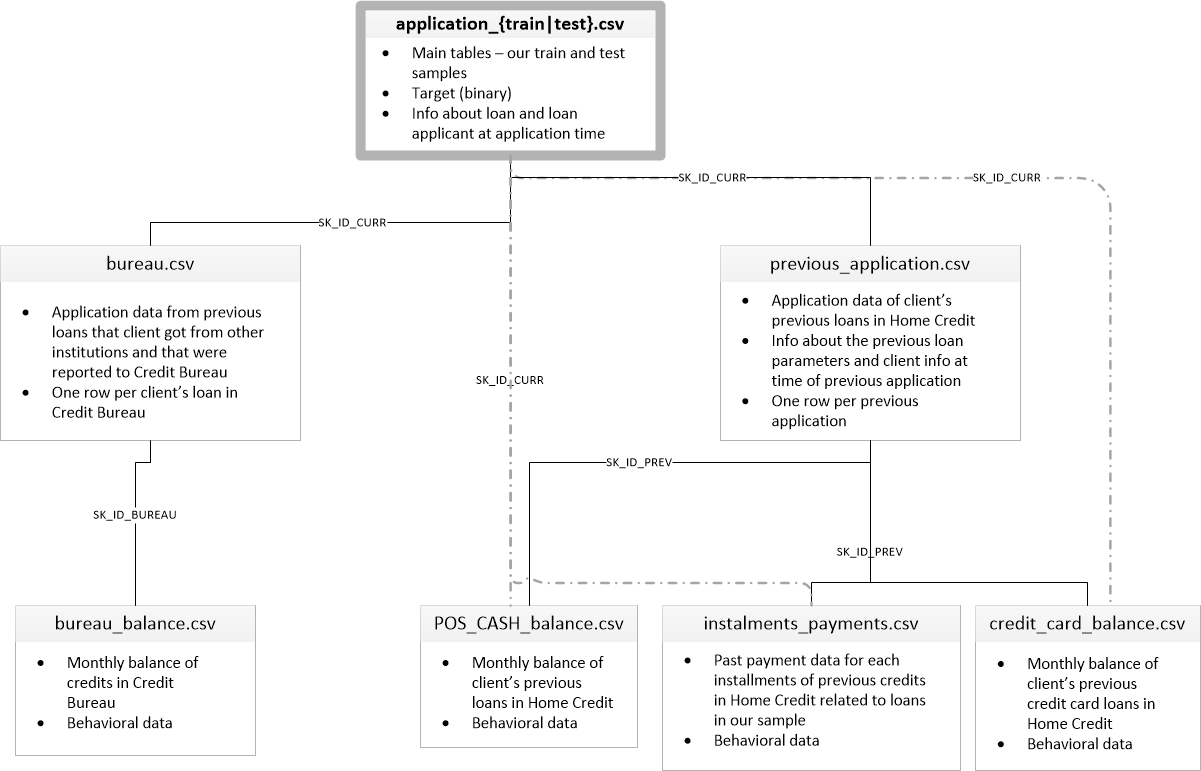

# 2 - Exploration initiale et nettoyage

## 2.1 - Analyses univariées

In [17]:
# On va augmenter l'affichage du nombre de lignes et de colonnes 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [18]:
# Regardons la description de toutes nos variables
df_HomeCredit_columns_description = pd.read_csv('/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
df_HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [19]:
# Liste des DataFrames et leurs noms correspondants
dataframes = {
    'df_application_train': df_application_train,
    'df_application_test': df_application_test,
    'df_bureau': df_bureau,
    'df_bureau_balance': df_bureau_balance,
    'df_credit_card_balance': df_credit_card_balance,
    'df_installments_payments': df_installments_payments,
    'df_POS_CASH_balance': df_POS_CASH_balance,
    'df_previous_application': df_previous_application
}

# Fonction pour résumer un DataFrame
def summarize_df(df, name):
    rows = df.shape[0]
    columns = df.shape[1]
    nan_pct = (df.isnull().sum().sum() / (rows * columns)) * 100
    duplicate_pct = (df.duplicated().sum() / rows) * 100
    object_dtype = df.select_dtypes(include=['object']).shape[1]
    float_dtype = df.select_dtypes(include=['float64']).shape[1]
    int_dtype = df.select_dtypes(include=['int64']).shape[1]
    bool_dtype = df.select_dtypes(include=['bool']).shape[1]
    mb_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)  # Convertir en MB
    
    return {
        'DataFrame': name,
        'Rows': rows,
        'Columns': columns,
        '%NaN': round(nan_pct, 2),
        '%Duplicate': round(duplicate_pct, 2),
        'object_dtype': object_dtype,
        'float_dtype': float_dtype,
        'int_dtype': int_dtype,
        'bool_dtype': bool_dtype,
        'MB_Memory': round(mb_memory, 3)
    }

In [20]:
# Créer le résumé pour tous les DataFrames
summary = [summarize_df(df, name) for name, df in dataframes.items()]

# Convertir en DataFrame pour l'affichage
df_summary = pd.DataFrame(summary)
df_summary

,DataFrame,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
0,df_application_train,307511,122,24.40,0.0,16,65,41,0,536.692
1,df_application_test,48744,121,23.81,0.0,16,65,40,0,84.735
2,df_bureau,1716428,17,13.50,0.0,3,8,6,0,512.111
3,df_bureau_balance,27299925,3,0.00,0.0,1,0,2,0,1926.608
4,df_credit_card_balance,3840312,23,6.65,0.0,1,15,7,0,875.688
5,df_installments_payments,13605401,8,0.01,0.0,0,5,3,0,830.408
6,df_POS_CASH_balance,10001358,8,0.07,0.0,1,2,5,0,1137.250
7,df_previous_application,1670214,37,17.98,0.0,16,15,6,0,1900.632


1. **Taille des DataFrames**
   - **`df_application_train`** et **`df_application_test`** sont les plus petits en termes de lignes par rapport aux autres DataFrames, mais ils ont le plus grand nombre de colonnes.
   - **`df_bureau_balance`** est de loin le plus grand en termes de nombre de lignes (27 millions), ce qui est attendu pour un historique détaillé des crédits.

2. **Présence de Valeurs Manquantes (%NaN)**
   - Les valeurs manquantes sont assez élevées dans `df_application_train` (24.40%) et `df_application_test` (23.81%). Cela peut indiquer des données incomplètes ou nécessiter un nettoyage approfondi avant la modélisation.
   - Les autres DataFrames ont des pourcentages de valeurs manquantes beaucoup plus faibles, ce qui suggère que les données sont relativement complètes pour ces fichiers.

3. **Duplication des Données (%Duplicate)**
   - Aucun des DataFrames n’a de duplications dans les données (`%Duplicate` est 0.0 pour tous les DataFrames). Cela est bon signe et signifie que les données sont uniques au niveau des lignes.

4. **Types de Données**
   - **`df_application_train`** et **`df_application_test`** contiennent une grande proportion de colonnes d’objets (16), ce qui suggère qu'il y a beaucoup de variables catégorielles. Les autres DataFrames ont un nombre beaucoup plus faible de colonnes d’objets.
   - Les types de données numériques (`float_dtype` et `int_dtype`) sont relativement bien répartis entre les DataFrames, bien que certains DataFrames comme `df_credit_card_balance` et `df_installments_payments` aient une prépondérance de types `float`.

5. **Utilisation de la Mémoire (MB_Memory)**
   - **`df_bureau_balance`** utilise la plus grande quantité de mémoire (1926.608 MB), suivie de près par `df_previous_application` (1900.632 MB). Ces DataFrames ont un grand nombre de lignes, ce qui contribue à leur utilisation élevée de la mémoire.
   - Les DataFrames plus petits comme `df_application_test` et `df_application_train` consomment beaucoup moins de mémoire, ce qui est proportionnel à leur taille plus petite en termes de lignes et de colonnes.

### 2.1.1 - df_application_train/test

In [21]:
# Informations sur df_application_train
df_application_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 536.7 MB


In [22]:
# df_application_train
print('Shape: ', df_application_train.shape)
df_application_train.head()

Shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [23]:
# Informations sur df_application_test
df_application_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 84.7 MB


In [24]:
# df_application_test
print('Shape: ', df_application_test.shape)
df_application_test.head()

Shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

<center><span style="font-size:18px; font-weight:bold;">Notre variable cible</span><center>

Il est important de bien comprendre la distribution de la variable cible (TARGET) car cela influencera les choix de modélisation et de traitement des données.

In [25]:
# Regardons la distribution de notre target
target_distribution = df_application_train['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)
df_application_train['TARGET'].value_counts()

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


TARGET
0    282686
1     24825
Name: count, dtype: int64

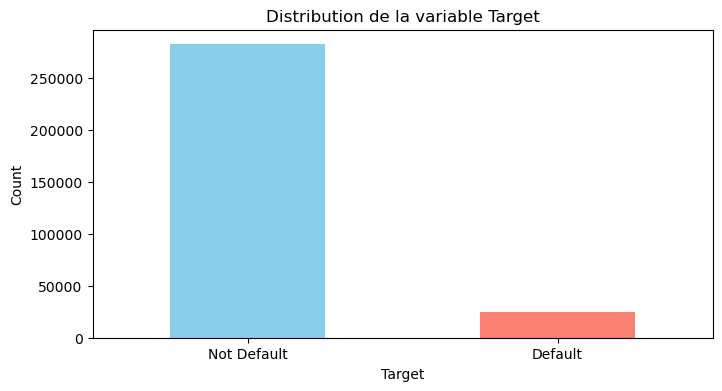

In [26]:
# Plot the target distribution
plt.figure(figsize=(8, 4))
df_application_train['TARGET'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution de la variable Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Default', 'Default'], rotation=0)
plt.show()

La distribution montre un déséquilibre entre les classes, avec une majorité d'échantillons dans la classe 0 (non défaillant) par rapport à la classe 1 (défaillant). Ce déséquilibre est assez fréquent dans les problèmes de classification, en particulier dans les cas de prédiction de défauts de crédit ou de fraude, où les événements de défaut sont généralement rares.


Le déséquilibre des classes peut affecter la performance du modèle de plusieurs façons :
- **Biais du Modèle** : Les modèles peuvent devenir biaisés vers la classe majoritaire (0 dans ce cas) et prédire principalement cette classe.
- **Évaluation du Modèle** : Les métriques classiques comme l'accuracy peuvent être trompeuses. Des métriques comme la précision, le rappel, la F-mesure, et la courbe ROC AUC sont souvent plus appropriées dans les cas de déséquilibre.


Pour traiter le déséquilibre des classes, nous pouvons utiliser plusieurs techniques :
- **Rééchantillonnage** : Utiliser des techniques de suréchantillonnage (par exemple, SMOTE) pour augmenter le nombre d'exemples de la classe minoritaire ou de sous-échantillonnage pour réduire le nombre d'exemples de la classe majoritaire.
- **Pondération des Classes** : Ajuster les poids des classes dans les algorithmes de classification pour donner plus d'importance à la classe minoritaire.
- **Modèles Spécifiques** : Utiliser des modèles conçus pour gérer les déséquilibres, comme les forêts d'arbres décisionnels équilibrées ou les algorithmes de boosting.

<center><span style="font-size:18px; font-weight:bold;">Type des colonnes</span><center>

In [27]:
# Nombre de colonnes de chaque type
df_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

- **Colonnes de Type `float64` :** **65**
  - Ces colonnes contiennent des données numériques à virgule flottante. Elles sont souvent utilisées pour les caractéristiques continues.
  
- **Colonnes de Type `int64` :** **41**
  - Ces colonnes contiennent des données numériques entières. Elles peuvent représenter des comptages, des indicateurs binaires, ou d'autres valeurs discrètes.
  
- **Colonnes de Type `object` :** **16**
  - Ces colonnes contiennent des données de type chaîne de caractères (texte). Elles peuvent inclure des variables catégorielles ou des données textuelles qui doivent être converties en format numérique pour la modélisation.

**Implications pour l'Analyse et le Nettoyage**

- **Colonnes `float64` et `int64` :** 
  - Ces colonnes peuvent nécessiter un traitement pour gérer les valeurs manquantes, les valeurs aberrantes, et la normalisation ou la standardisation des données. 

- **Colonnes `object` :**
  - Les colonnes de type `object` doivent être converties en format numérique avant de pouvoir être utilisées dans les modèles de machine learning. Cela peut être fait par :
    - **Encodage des Catégories :** Utiliser des techniques d'encodage telles que l'encodage par étiquettes (`Label Encoding`) ou l'encodage one-hot (`One-Hot Encoding`) pour transformer les variables catégorielles en variables numériques.
    - **Gestion des Valeurs Manquantes :** Les colonnes de type `object` peuvent contenir des valeurs manquantes ou des catégories peu fréquentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs manquantes</span><center>

In [28]:
# Fonction qui va calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

L'analyse des valeurs manquantes est une étape importante dans le prétraitement des données, surtout lorsqu'il s'agit de préparer les données pour des modèles de machine learning. 

Pour les colonnes avec des pourcentages très élevés de valeurs manquantes :
- **Évaluer la Pertinence**: Déterminer si ces colonnes sont importantes pour notre analyse ou notre modèle. Si elles sont peu informatives ou redondantes, envisager de les supprimer.
- **Imputation ou Suppression**:
  - **Suppression**: Si une colonne a un pourcentage élevé de valeurs manquantes et n’est pas essentielle, nous pouvons la supprimer.
  - **Imputation**: Pour les colonnes essentielles, nous pouvons choisir une méthode d’imputation, comme la moyenne, la médiane, ou une méthode basée sur d’autres colonnes (comme la régression ou les techniques d’imputation avancées).

In [29]:
# Affichons les valeurs manquantes :
missing_values = missing_values_table(df_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [30]:
# Affichons les valeurs manquantes :
missing_values_test = missing_values_table(df_application_test)
missing_values_test.head(20)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


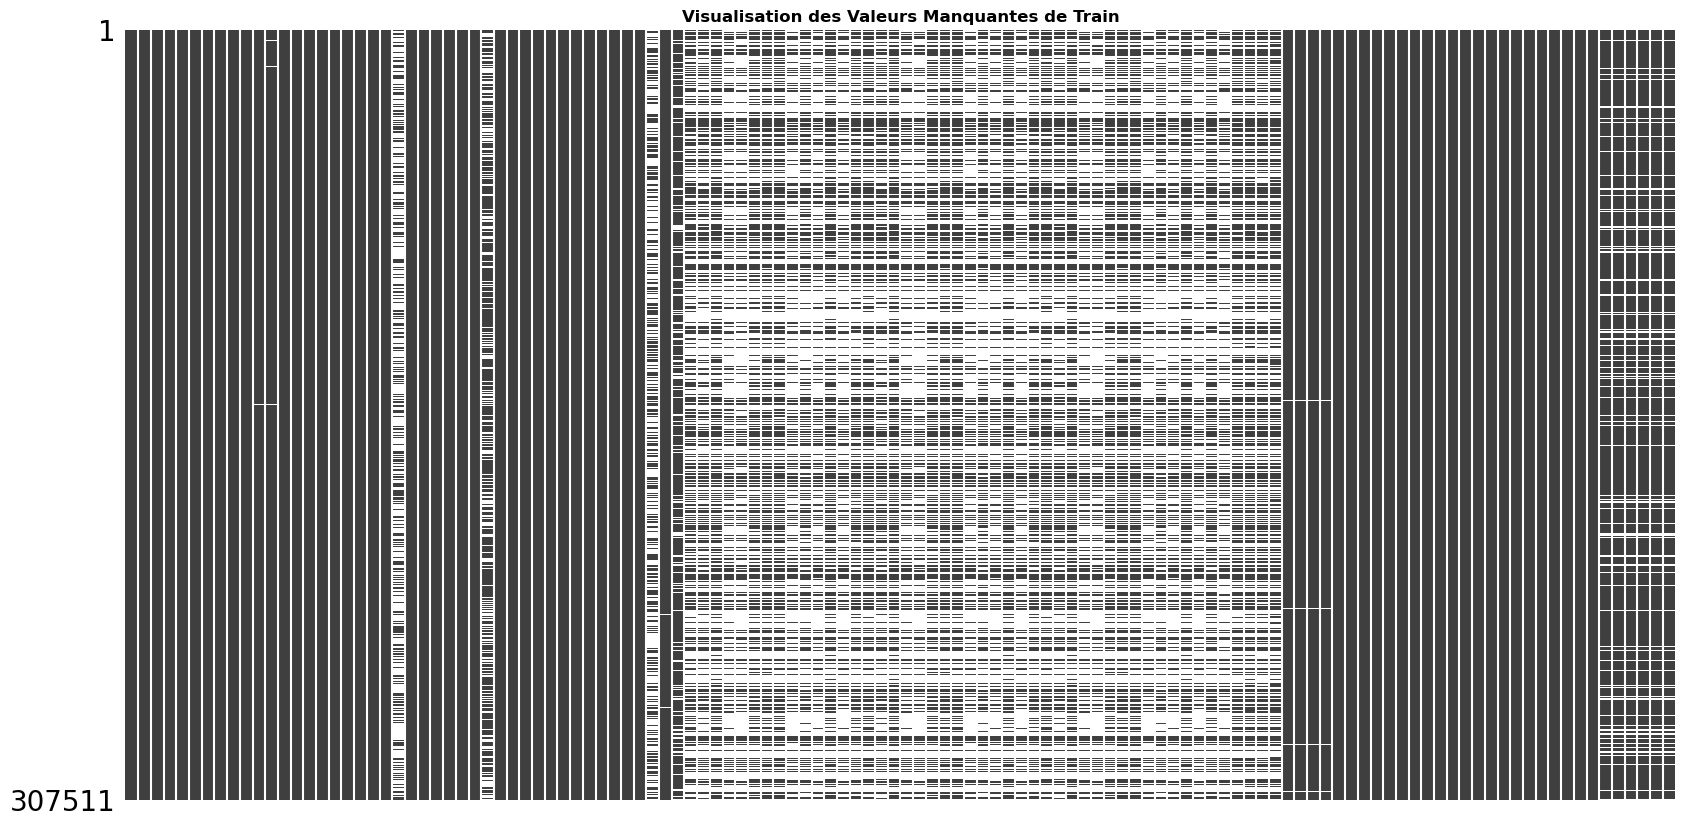

In [31]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_train, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Train", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

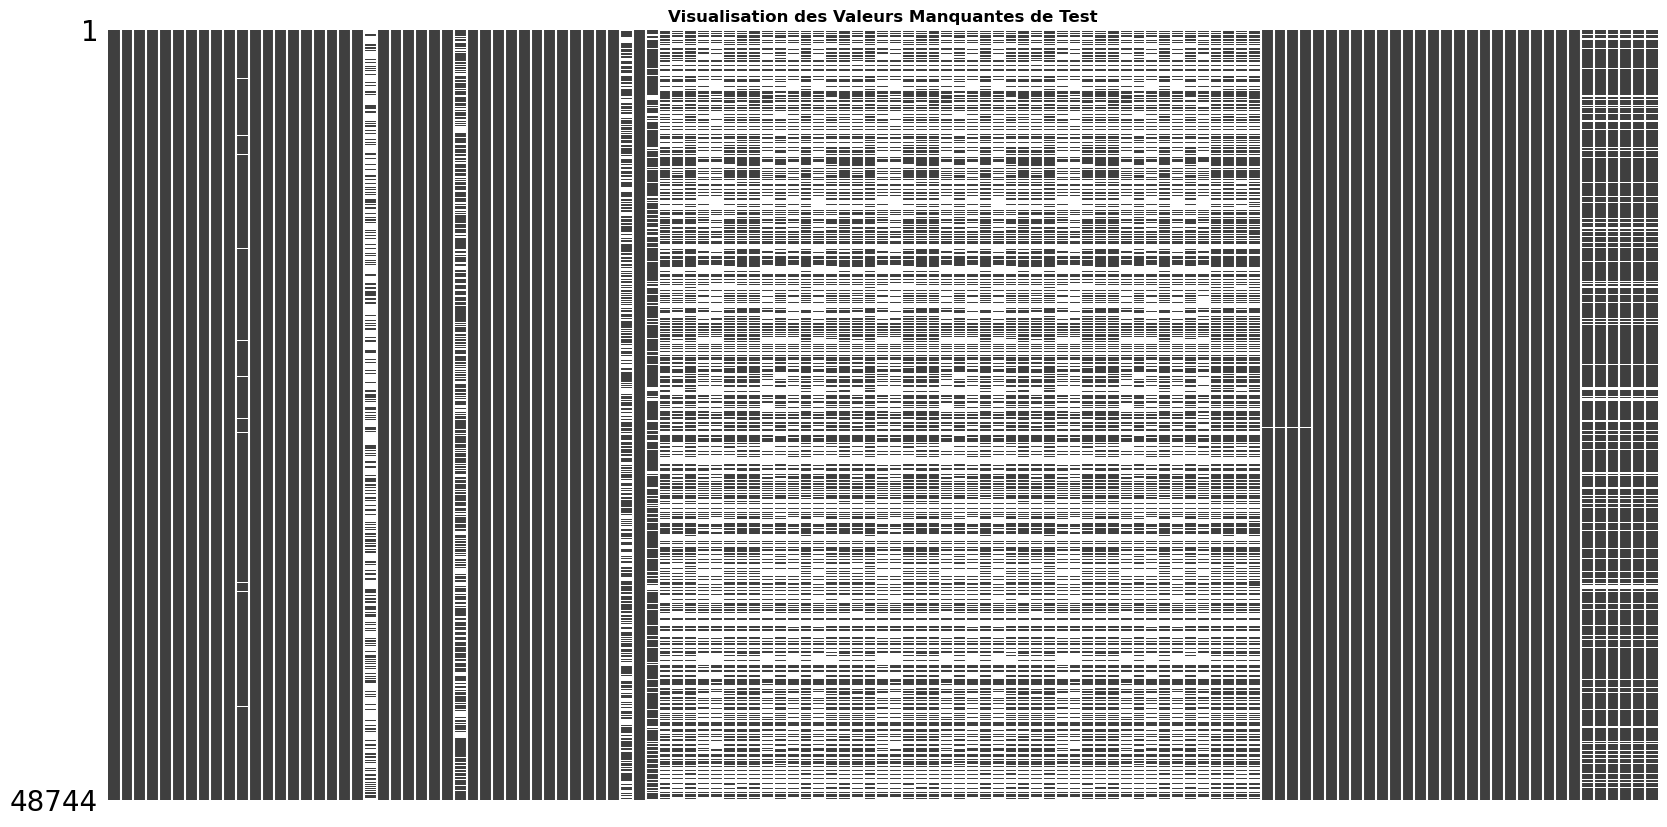

In [32]:
# Et on visualise les valeurs manquantes avec missingno :
msno.matrix(df_application_test, figsize=(20, 10), sparkline=False)
plt.title("Visualisation des Valeurs Manquantes de Test", fontsize=12, fontweight="bold")
plt.xticks(fontsize=8)
plt.show()

En modélisation, notamment avec des algorithmes comme XGBoost, il est souvent possible de gérer les valeurs manquantes directement, car ces modèles peuvent travailler avec des données incomplètes de manière plus robuste que certains autres types de modèles. 

1. **Distribution des Valeurs Manquantes**
   - **Colonnes Concernées**: Les valeurs manquantes sont principalement concentrées dans les caractéristiques liées aux habitats et non dans les variables liées aux crédits.
   - **TOP 20 des Colonnes avec Plus de NaN**: Les colonnes relatives aux caractéristiques des habitats (comme `COMMONAREA_MEDI`, `LIVINGAPARTMENTS_MODE`, etc.) présentent des taux très élevés de valeurs manquantes.

&nbsp;
2. **Implications pour le Modèle**
   - **Impact Potentiel**: Les caractéristiques avec des valeurs manquantes élevées peuvent influencer la qualité de la modélisation si elles sont importantes pour la prédiction. Cependant, les modèles comme XGBoost peuvent traiter les NaN nativement, ce qui simplifie la prétraitement des données.
   - **Évaluation de l'Importance**: Puisqu'on ne peut pas toujours anticiper l'importance de ces variables pour le modèle, il est prudent de ne pas les éliminer immédiatement sans analyse plus approfondie.

&nbsp;
3. **Analyse de l'Importance des Variables**
   - **Importance des Variables**: Nous allons utiliser des méthodes comme l’analyse de l'importance des variables (feature importance) après une première modélisation pour identifier quelles variables sont réellement pertinentes.

<center><span style="font-size:18px; font-weight:bold;">Valeurs uniques</span><center>

Analyser le nombre de valeurs uniques dans les colonnes catégorielles va nous aider à comprendre la diversité des catégories présentes dans notre dataset.

In [33]:
# Nombre de valeurs uniques pour les colonnes object
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1. **Colonnes avec Peu de Catégories**
   - **`NAME_CONTRACT_TYPE`, `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `EMERGENCYSTATE_MODE`**:
     - Ces colonnes ont 2 valeurs uniques, ce qui indique qu’elles contiennent des variables binaires. Elles sont généralement simples à traiter car elles ne nécessitent pas une grande complexité pour la modélisation.

2. **Colonnes avec Modéré Nombre de Catégories**
   - **`NAME_TYPE_SUITE`, `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, `NAME_HOUSING_TYPE`, `WEEKDAY_APPR_PROCESS_START`, `FONDKAPREMONT_MODE`, `HOUSETYPE_MODE`, `WALLSMATERIAL_MODE`**:
     - Ces colonnes ont un nombre modéré de valeurs uniques (entre 3 et 18). Elles contiennent des variables catégorielles avec plusieurs options, ce qui peut nécessiter une transformation en variables numériques (par exemple, via l'encodage).

3. **Colonnes avec Nombre Élevé de Catégories**
   - **`OCCUPATION_TYPE`, `ORGANIZATION_TYPE`**:
     - Ces colonnes ont un grand nombre de valeurs uniques (respectivement 18 et 58). Elles représentent des variables avec une grande diversité de catégories, ce qui peut nécessiter des techniques spécifiques comme l'encodage par entités, ou l'utilisation de méthodes pour gérer le cardinalité élevée.

<center><span style="font-size:18px; font-weight:bold;">Encodage des variables catégorielles</span><center>

1. **Encodage des Variables Catégorielles**
   - **Variables Binaires**: Les colonnes avec 2 valeurs uniques peuvent être converties en variables binaires directement (0 ou 1).
   - **Variables avec Modéré Nombre de Catégories**: Nous pouvons utiliser l'encodage one-hot (ou dummies) pour ces variables. Cette méthode crée des colonnes supplémentaires pour chaque catégorie.
   - **Variables avec Nombre Élevé de Catégories**: Pour les variables avec un grand nombre de catégories, nous pouvons envisager l’encodage par entités ou le regroupement des catégories rares. L'encodage one-hot peut entraîner un très grand nombre de colonnes, ce qui peut ne pas être optimal.

2. **Gestion des Variables à Cardinalité Élevée**
   - **Réduction de Cardinalité**: Nous pouvons regrouper les catégories rares ou peu fréquentes sous une catégorie commune (par exemple, "Autre").
   - **Encodage par Entités**: Nous pouvons utiliser des techniques d'encodage basées sur les cibles (target encoding) ou des encodages fréquents pour ces colonnes.

Le code suivant sert à encoder les colonnes catégorielles avec un nombre de valeurs uniques inférieur ou égal à 2 en utilisant `LabelEncoder` de la bibliothèque `sklearn`.

In [35]:
# Création du LabelEncoder
le = LabelEncoder()
le_count = 0

# Itérons toutes les colonnes
for col in df_application_train:
    if df_application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application_train[col])
            # Transform both training and testing data
            df_application_train[col] = le.transform(df_application_train[col])
            df_application_test[col] = le.transform(df_application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


Le `one-hot encoding` suivant va transformer nos variables catégorielles en colonnes binaires pour chaque valeur unique.

In [36]:
# One-hot encoding des variables catégorielles
df_application_train = pd.get_dummies(df_application_train)
df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Il y a une différence dans le nombre de colonnes entre les ensembles de données d'entraînement et de test :
- **Entraînement**: 243 colonnes
- **Test**: 239 colonnes

Cette différence de colonnes est souvent due à des catégories présentes dans l'ensemble d'entraînement mais absentes dans l'ensemble de test (ou vice versa). Cela peut poser problème pour les modèles, car chaque ensemble de données doit avoir les mêmes colonnes pour que la modélisation soit cohérente.

Nous pouvons résoudre ce problème en garantissant que les deux ensembles de données (entraînement et test) ont les mêmes colonnes après `one-hot encoding`.

In [37]:
train_labels = df_application_train['TARGET']

# Alignons les deux ensembles, en ne gardant que les colonnes présentent dans les deux dataframes
df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)

# On rajout la TARGET
df_application_train['TARGET'] = train_labels

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


<center><span style="font-size:18px; font-weight:bold;">Gestion des anomalies</span><center>

Un problème auquel nous devons toujours être attentifs lors de l'exploration des données est la détection des anomalies. Celles-ci peuvent être dues à des erreurs de saisie, des problèmes avec les équipements de mesure, ou bien elles peuvent représenter des mesures valides mais extrêmes. Une façon de détecter quantitativement les anomalies est d'examiner les statistiques d'une colonne en utilisant la méthode `describe`."

In [38]:
# Cherchons des anomalies pour nos variables integer
df_application_train.select_dtypes('int64').describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.080729
std,102790.175348,0.293509,0.473746,0.460968,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.0000

In [39]:
# Cherchons des anomalies pour nos variables float
df_application_train.select_dtypes('float64').describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

In [40]:
# Regardons notre variable DAYS_BIRTH
df_application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [41]:
# Nous pouvons voir ces stats en années
(df_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

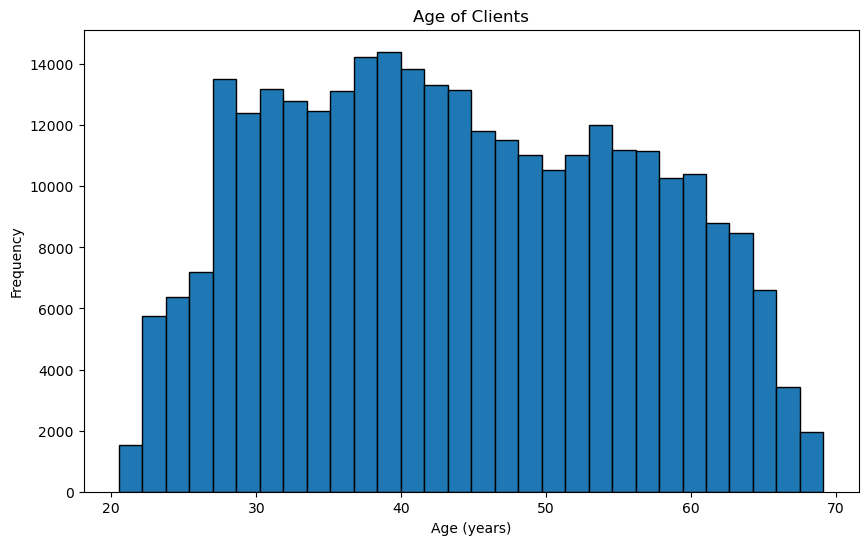

In [42]:
# Convertissons DAYS_BIRTH en âge en années
df_application_train['AGE'] = -df_application_train['DAYS_BIRTH'] / 365

# Créons l'histogramme
plt.figure(figsize=(10, 6))
df_application_train['AGE'].plot.hist(bins=30, edgecolor='black')
plt.title('Age of Clients')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

1. `DAYS_BIRTH`

- **Moyenne (`mean`)**: -16037 jours, soit environ 43,9 ans.
- **Minimum (`min`)**: -25229 jours, soit environ 69,1 ans.
- **Maximum (`max`)**: -7489 jours, soit environ 20,5 ans.

La colonne `DAYS_BIRTH` représente l'âge des clients en jours avant la date de l'enregistrement. Les valeurs sont négatives, car elles sont comptées à rebours à partir de la date de l'enregistrement.

- **Âge minimum** : La valeur minimale de -25229 jours correspond à environ 69,1 ans. Cela semble réaliste pour une base de données de clients d'une institution financière.
- **Âge maximum** : La valeur maximale de -7489 jours correspond à environ 20,5 ans, ce qui pourrait indiquer que des personnes assez jeunes (potentiellement début de carrière) sont également présentes dans cette base de données.

Les valeurs semblent toutes plausibles et aucune anomalie évidente n'est observée ici. Qu'en est-il de la durée des contrats de travail ?

In [43]:
# Regardons notre variable DAYS_EMPLOYED
df_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

2. `DAYS_EMPLOYED`

- **Moyenne (`mean`)**: 63815 jours, ce qui est clairement anormal et indique la présence d'une anomalie.
- **Minimum (`min`)**: -17912 jours, soit environ 49 ans d'emploi.
- **Maximum (`max`)**: 365243 jours, soit environ 1000 ans d'emploi, ce qui est impossible.

La colonne `DAYS_EMPLOYED` représente le nombre de jours pendant lesquels le client a été employé. Les valeurs positives indiquent une anomalie évidente.

- **Anomalie majeure** : La valeur maximale de 365243 jours est irréaliste (environ 1000 ans d'emploi). Cette valeur est probablement utilisée comme un code pour représenter des valeurs manquantes ou des cas particuliers où les informations d'emploi ne sont pas disponibles.
- **Valeurs négatives** : Les valeurs négatives semblent logiques, car elles indiquent le nombre de jours depuis le début de l'emploi jusqu'à la date de l'enregistrement, avec des valeurs correspondant à des périodes d'emploi réalistes.

Par curiosité, examinons un sous-ensemble des clients présentant ces anomalies pour voir s'ils ont tendance à avoir des taux de défaut plus élevés ou plus bas que le reste des clients.

In [44]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


1. **Taux de défaut pour les non-anomalies :**  
   - Les clients sans anomalies dans `DAYS_EMPLOYED` (c'est-à-dire ceux pour lesquels les jours d'emploi ne sont pas égaux à 365243) ont un taux de défaut de **8,66%**.
  
2. **Taux de défaut pour les anomalies :**  
   - Les clients avec l'anomalie (DAYS_EMPLOYED = 365243) ont un taux de défaut de **5,40%**.
  
3. **Nombre d'anomalies détectées :**  
   - Il y a **55 374** clients avec des valeurs anormales dans `DAYS_EMPLOYED`.

**Interprétation**

- **Taux de défaut inférieur pour les anomalies :**
  - Étonnamment, les clients avec l'anomalie `DAYS_EMPLOYED` semblent avoir un taux de défaut inférieur (5,40%) par rapport aux autres clients (8,66%). 
  - Cela pourrait indiquer que ces anomalies sont associées à un sous-ensemble spécifique de clients, potentiellement des retraités, des personnes sans emploi mais ayant d'autres formes de revenu stables, ou des cas particuliers où l'emploi n'est pas la principale source de revenus.
  
- **Implications pour le modèle :**
  - **Prise en compte des anomalies :** Cette différence de comportement suggère que ces anomalies ne devraient pas simplement être ignorées, mais plutôt traitées comme une catégorie spéciale dans la modélisation. Par exemple, nous pourrions ajouter une variable binaire (comme `DAYS_EMPLOYED_ANOM`) pour indiquer la présence de cette anomalie.
  - **Stratégies de modélisation :** Le fait que ces clients aient un taux de défaut inférieur pourrait influencer la performance de certains modèles si cette information n'est pas correctement intégrée.

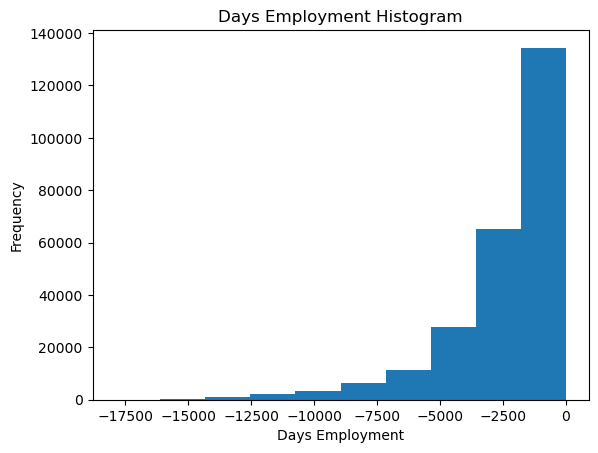

In [45]:
# Créons une variable DAYS_EMPLOYED_ANOM
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Remplaçons les anomalies par des nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble désormais beaucoup plus conforme à ce que nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine des anomalies (car nous devrons remplir les valeurs manquantes avec une valeur, probablement la médiane de la colonne). Les autres colonnes contenant des données en jours dans le dataframe semblent être conformes à nos attentes, sans valeurs aberrantes évidentes.

Il est extrêmement important de noter que tout ce que nous faisons aux données d'entraînement doit également être fait aux données de test. Assurons-nous donc de créer la nouvelle colonne et de remplir la colonne existante avec np.nan dans les données de test également.

In [46]:
# Faisons de même pour les données de test
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


## 2.2 - Analyses bivariées

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, poursuivons l'exploration des données. Une façon de comprendre les données est d'examiner les corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode `.corr` du dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles dans les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

- **.00-.19** : "très faible"
- **.20-.39** : "faible"
- **.40-.59** : "modéré"
- **.60-.79** : "fort"
- **.80-1.0** : "très fort"

In [47]:
# Trouvons les corrélations avec la variable TARGET
correlations = df_application_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Analysons les résultats des corrélations entre les caractéristiques et la variable cible `TARGET` pour comprendre quelles variables semblent avoir le plus d'impact potentiel sur la probabilité de défaut de paiement. 

**Corrélations Positives**

Voici les caractéristiques qui montrent les plus fortes corrélations positives avec la cible (`TARGET`), c’est-à-dire celles qui augmentent légèrement la probabilité de défaut :

1. **DAYS_BIRTH (0.078239)** : L'âge du client a une corrélation positive avec la probabilité de défaut, bien que cette corrélation soit assez faible. En général, une augmentation de l'âge pourrait être associée à un risque légèrement plus élevé, mais d'autres facteurs doivent être considérés.

2. **DAYS_EMPLOYED (0.074958)** : Le nombre de jours depuis le début de l'emploi est positivement corrélé à la probabilité de défaut. Cela pourrait indiquer que des emplois plus récents sont associés à un risque légèrement plus élevé, mais la corrélation est faible.

3. **NAME_INCOME_TYPE_Working (0.057481)** : Les clients dont le type de revenu est "Travailleur" ont une corrélation légèrement positive avec la probabilité de défaut.

4. **REGION_RATING_CLIENT_W_CITY (0.060893)** et **REGION_RATING_CLIENT (0.058899)** : La notation de la région du client montre une faible corrélation positive, ce qui peut indiquer une légère relation entre la région et la probabilité de défaut.

**Corrélations Négatives**

Voici les caractéristiques qui montrent les plus fortes corrélations négatives avec la cible, c’est-à-dire celles qui sont associées à une probabilité plus faible de défaut :

1. **EXT_SOURCE_1 (-0.155317)**, **EXT_SOURCE_2 (-0.160472)**, **EXT_SOURCE_3 (-0.178919)** : Les variables `EXT_SOURCE` montrent une corrélation négative plus significative avec la cible. Ces variables externes, souvent des scores de crédit, sont généralement associées à un risque plus faible de défaut de paiement.

2. **AMT_GOODS_PRICE (-0.039645)** : Le montant des biens achetés a une faible corrélation négative avec la probabilité de défaut. Un montant plus élevé pourrait être associé à une probabilité légèrement plus faible de défaut, ce qui pourrait être lié à un pouvoir d'achat plus élevé ou à une meilleure gestion financière.

3. **NAME_EDUCATION_TYPE_Higher education (-0.056593)** : Le niveau d'éducation supérieur a une corrélation négative avec la probabilité de défaut, suggérant que les clients avec un niveau d'éducation plus élevé sont légèrement moins susceptibles de faire défaut.

<center><span style="font-size:18px; font-weight:bold;">Effet de l'âge sur le défault de paiement</span><center>

In [48]:
# Trouvons la corrélation entre les jours positifs depuis la naissance et la TARGET
df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])
df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET'])

-0.07823930830982694

La corrélation de **-0.078** entre l'âge (représenté par `DAYS_BIRTH`) et la variable cible `TARGET` indique une relation faible mais négative. Voici quelques interprétations et points à considérer pour comprendre cet effet :

1. **Relation Faible**:
   - Une corrélation de **-0.078** est relativement faible, ce qui suggère que l'âge du client a une influence limitée sur la probabilité de défaut de paiement. La relation est négative, ce qui signifie qu'en général, les clients plus âgés ont une probabilité légèrement plus faible de défaut, mais cette tendance est très faible.

2. **Absence de Relation Forte**:
   - Étant donné que la corrélation est faible, l'âge n'explique qu'une petite partie de la variation dans le défaut de paiement. Cela indique que d'autres facteurs peuvent être plus importants pour prédire le risque de défaut.

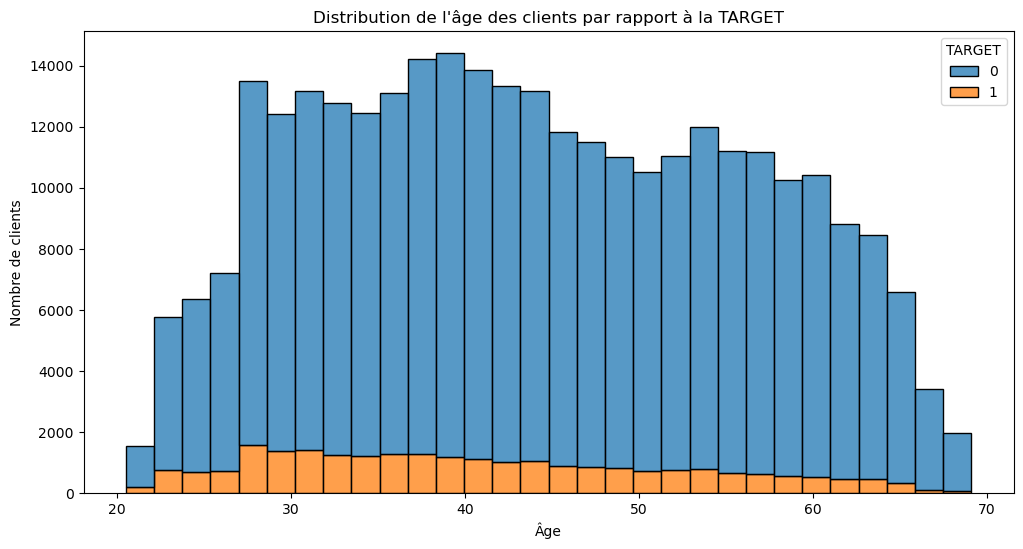

In [52]:
# Transformons DAYS_BIRTH en années
df_application_train['AGE'] = -df_application_train['DAYS_BIRTH'] / -365

# Visualisons la distribution de l'âge par rapport à la TARGET
plt.figure(figsize=(12, 6))
sns.histplot(data=df_application_train, x='AGE', hue='TARGET', multiple='stack', bins=30)
plt.title('Distribution de l\'âge des clients par rapport à la TARGET')
plt.xlabel('Âge')
plt.ylabel('Nombre de clients')
plt.show()

La distribution de l'âge en faisant apparaître les défaults nous renseigne un peu sur nos individus, on peut également voir qu'il n'y a pas de valeurs aberrantes puisque tous les âges semblent raisonnables. Pour mieux visualiser l'effet de l'âge sur la cible, nous allons créer un graphique d'estimation de densité par noyau (KDE) coloré en fonction de la valeur de la cible. Un graphique d'estimation de densité par noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement gaussien, pour chaque point de données, puis en moyenne tous les noyaux individuels pour développer une courbe lisse unique). Nous utiliserons la fonction `kdeplot` de Seaborn pour ce graphique.

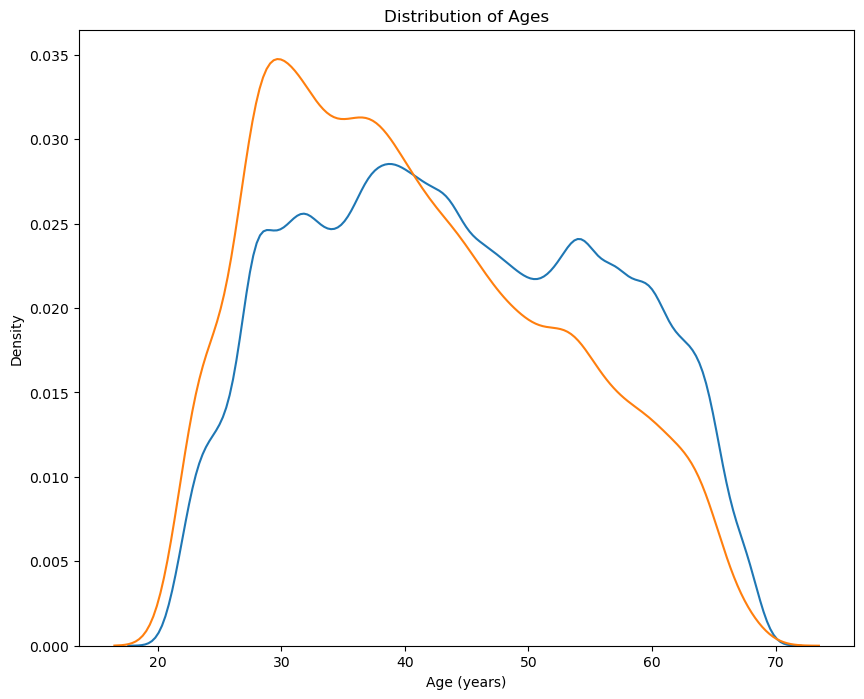

In [53]:
plt.figure(figsize = (10, 8))

# KDE plot des crédits payés à temps
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot des crédits non payés à temps
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe pour **target == 1** tend vers les âges plus jeunes. Bien que la corrélation ne soit pas significative (-0,07 pour le coefficient de corrélation), cette variable est probablement utile dans un modèle d'apprentissage automatique car elle a un effet sur la cible. Examinons cette relation d'une autre manière : le taux de défaut de remboursement des prêts par tranche d'âge.

Pour créer ce graphique, nous allons d'abord diviser les âges en tranches de 5 ans. Ensuite, pour chaque tranche, nous calculerons la valeur moyenne de la cible, ce qui nous indiquera le ratio de prêts non remboursés dans chaque tranche d'âge.

In [55]:
# Création d'un dataframe pour l'âge
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Création des tranches d'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11), right=False)

# Affichage des premières lignes pour vérifier
print(age_data.head(10))

   TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  [25.0, 30.0)
1       0       16765    45.931507  [45.0, 50.0)
2       0       19046    52.180822  [50.0, 55.0)
3       0       19005    52.068493  [50.0, 55.0)
4       0       19932    54.608219  [50.0, 55.0)
5       0       16941    46.413699  [45.0, 50.0)
6       0       13778    37.747945  [35.0, 40.0)
7       0       18850    51.643836  [50.0, 55.0)
8       0       20099    55.065753  [55.0, 60.0)
9       0       14469    39.641096  [35.0, 40.0)


In [56]:
# Calcul du taux de défaut pour chaque tranche d'âge
age_group_default_rate = age_data.groupby('YEARS_BINNED')['TARGET'].mean().reset_index()

# Affichage des taux de défaut par tranche d'âge
print(age_group_default_rate)

   YEARS_BINNED    TARGET
0  [20.0, 25.0)  0.123128
1  [25.0, 30.0)  0.111385
2  [30.0, 35.0)  0.102868
3  [35.0, 40.0)  0.089314
4  [40.0, 45.0)  0.078593
5  [45.0, 50.0)  0.074159
6  [50.0, 55.0)  0.066997
7  [55.0, 60.0)  0.055294
8  [60.0, 65.0)  0.052779
9  [65.0, 70.0)  0.037183


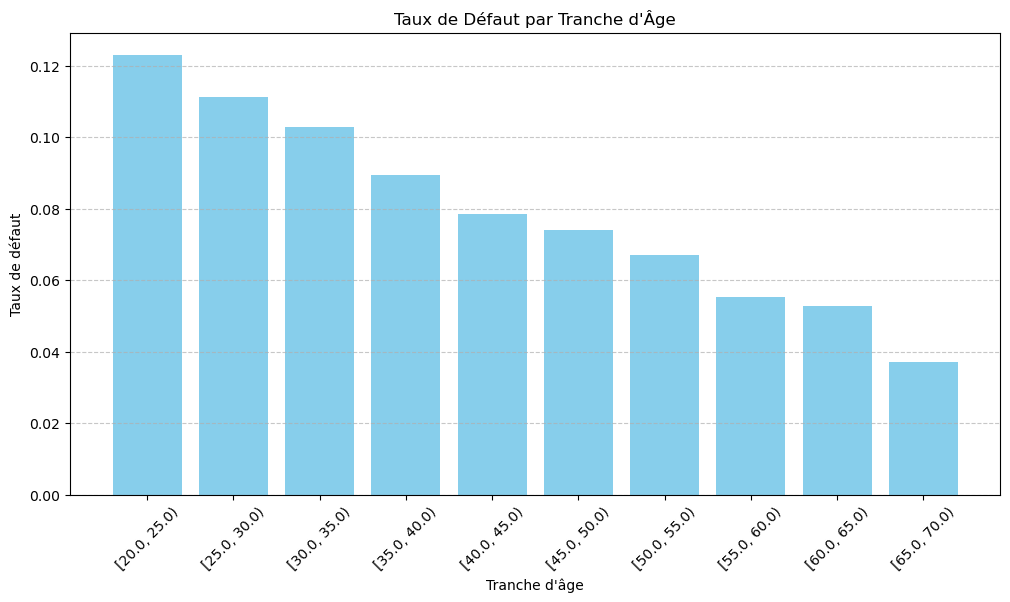

In [58]:
plt.figure(figsize=(12, 6))

# Tracer le taux de défaut pour chaque tranche d'âge
plt.bar(age_group_default_rate['YEARS_BINNED'].astype(str), age_group_default_rate['TARGET'], color='skyblue')

# Ajouter les labels et le titre
plt.xlabel('Tranche d\'âge')
plt.ylabel('Taux de défaut')
plt.title('Taux de Défaut par Tranche d\'Âge')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()


Il y a une tendance claire : les jeunes sont plus susceptibles de ne pas rembourser le prêt ! Le taux de défaut de remboursement est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus âgée.

Cette information pourrait être directement utilisée par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il serait peut-être judicieux de leur fournir davantage de conseils ou de recommandations en matière de gestion financière. Cela ne signifie pas que la banque devrait discriminer les jeunes clients, mais il serait prudent de prendre des mesures préventives pour aider les jeunes clients à payer à temps.

<center><span style="font-size:18px; font-weight:bold;">Les sources extérieures</span><center>

Pour examiner les variables avec les corrélations négatives les plus fortes par rapport à la cible, nous allons nous concentrer sur **EXT_SOURCE_1**, **EXT_SOURCE_2**, et **EXT_SOURCE_3**. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant de sources de données externes". Bien que le sens exact ne soit pas clair, il pourrait s'agir d'une sorte de cote de crédit cumulative basée sur diverses sources de données.

In [59]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


# 3 - Création du df_final

Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations.

In [ ]:
# On va créer un premier dataframe en faisant un merge de df_application_train et df_application_test
df_final = df_application_train.append(df_application_test)

Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.

In [ ]:
print('Train:' + str(application_train.shape))
print('Test:' + str(application_test.shape))
print('>>> Data:' + str(data.shape))

In [ ]:
# Vérifions nos valeurs manquantes de TARGET dans notre df_final
df_final.TARGET.isna().sum()

A partir du fichier bureau.csv, il est possible d'extraire un historique sur les précédents crédits enregistrés par les clients. Il peut donc être intéressant d'enrichir l'échantillon avec ce type de données.